# Starting a gym/fitness area in Metro Manila

## Introduction

The Philippines is an island country in South-East Asia with a population of more than 100 million [https://www.psa.gov.ph/content/highlights-philippine-population-2015-census-population]. It is the 8th most populated country in Asia, and 12th most populated country in the world [https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population]. It is also an emerging economy - currently it is the 36th largest economy by GDP in the world [https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)] and is projected to grow to be the 20th largest by 2050 [http://www.goldmansachs.com/our-thinking/archive/archive-pdfs/brics-book/brics-chap-13.pdf].

Metro Manila is the most densely populated metropolitan area in the Philippines, and the 5th most densely populated in the world [https://en.wikipedia.org/wiki/List_of_largest_cities]. It also accounts for 37.2% of the Philippine GDP [https://en.wikipedia.org/wiki/Economy_of_the_Philippines].

As an economy grows and the population get more spending power, so will the need for non-essential goods and services. For this reason, I would like to look at the best place to setup gym/fitness area in Metro Manila - mainly because it accounts for a large part of the economy, and there is good access to a large population. With this, we can now determine our problem statement:

## Problem

**Which area should I set up a new gym/fitness area in Metro Manila?**

For the scope of this capstone, we need to look at two things:

1. **Size of potential market**

    - Having a large potential customer base would be a big factor in starting a business. We can determine this by picking districts from the cities with the largest per capita income. We will be looking at this in combination with population density.

    
2. **Competitors in the area**

    - Having competitors in the area is also a big factor. Putting a business where there are no competing establishments would benefit us positively. We will determine this by getting data on nearby venues in foursquare, and by checking the venue types related to gyms and recreation.

## Data sources

To do this analysis, we will need to get raw data from a few places:

- the list of cities in Metro Manila: https://en.wikipedia.org/wiki/Metro_Manila
- population densities for the respective cities
- income per capita in Metro Manila: https://psa.gov.ph/sites/default/files/attachments/hsd/article/Table%202%20AVERAGE%20PER%20CAPITA%20INCOME%20AND%20AVERAGE%20PER%20CAPITA%20EXPENDITURE.pdf
- districts in the target cities in Metro Manila: https://en.wikipedia.org/wiki/List_of_ZIP_codes_in_the_Philippines
- the list of gym/recreation venues in selected districts via foursquare

## Methodology

### Cities in Metro Manila

The metropolitan Manila area is made up of several cities, each with their own districts. To get the list of cities, we will use the Wikipedia page for Metro Manila, which has the latest data from the Philippines' National Statistical Coordination Board.

In [38]:
import numpy as np
import pandas as pd
import requests

metro_manila_page_tables = pd.read_html("https://en.wikipedia.org/wiki/Metro_Manila", header=0)

The cities table is the fifth table in the Wikipedia page:

In [39]:
cities_table = metro_manila_page_tables[5]
cities_table.rename(
    columns={
        'City ormunicipality': 'City',
        'Population (2015)[3]': 'DROPColumn',
        'Population (2015)[3].1': 'Population',
        'Area[a]': 'AreaKM',
        'Area[a].1': 'AreaMi',
        'Density': 'DensityKM',
        'Density.1': 'DensityMi',
        'Incorporated (city)': 'Incorporated',
    }, inplace=True)
cities_table = cities_table.drop(cities_table.loc[cities_table['City'] == 'Pateros'].index) # Pateros is not a city, we'll consider it part of Taguig
cities_table = cities_table.drop(0) # drop duplicate header row in the wiki
cities_table = cities_table.drop(18) # drop the Total row
cities_table = cities_table.drop(19) # drop the annotations row
cities_table.loc[cities_table['City'] == "† City of Manila", ['City']] = 'Manila' # Let's call the City of Manila just Manila for easy joining with the other tables
cities_table = cities_table[['City', 'Population', 'AreaKM']].astype({ 'Population': float, 'AreaKM': float })
cities_table.set_index("City", inplace=True)
cities_table

Population  AreaKM
City                           
Caloocan      1583978.0   53.33
Las Piñas      588894.0   32.02
Makati         582602.0   27.36
Malabon        365525.0   15.96
Mandaluyong    386276.0   11.06
Manila        1780148.0   42.88
Marikina       450741.0   22.64
Muntinlupa     504509.0   41.67
Navotas        249463.0   11.51
Parañaque      664822.0   47.28
Pasay          416522.0   18.64
Pasig          755300.0   31.46
Quezon City   2936116.0  165.33
San Juan       122180.0    5.87
Taguig         804915.0   45.18
Valenzuela     620422.0   45.75

### Population density

We do not have population density by district available in the National Statistics Office database. What we do have is the density by city. We can use this data to calculate the density per area, and use it in the decision making process for picking which district to set up our business.

The table in Wikipedia already has population density per KM, but it is rounded up, so we will calculate it using the population data and land areas instead.

In [40]:
cities_table['Density'] = cities_table['Population'] / cities_table['AreaKM']
cities_table.sort_values('Density', ascending=False, inplace=True)
cities_table

Population  AreaKM       Density
City                                         
Manila        1780148.0   42.88  41514.645522
Mandaluyong    386276.0   11.06  34925.497288
Caloocan      1583978.0   53.33  29701.443840
Pasig          755300.0   31.46  24008.264463
Malabon        365525.0   15.96  22902.568922
Pasay          416522.0   18.64  22345.600858
Navotas        249463.0   11.51  21673.588184
Makati         582602.0   27.36  21293.932749
San Juan       122180.0    5.87  20814.310051
Marikina       450741.0   22.64  19909.054770
Las Piñas      588894.0   32.02  18391.442848
Taguig         804915.0   45.18  17815.737052
Quezon City   2936116.0  165.33  17759.124176
Parañaque      664822.0   47.28  14061.379019
Valenzuela     620422.0   45.75  13561.136612
Muntinlupa     504509.0   41.67  12107.247420

### Per capita income

We use the latest data for per capita income with city breakdowns from the Philippine Statistics Agency and associate the data with the cities in our table.

In [41]:
# The data is in the form of a PDF, so we use tabula-py's read_pdf function
# The data we need is in page 1 of the document
from tabula import read_pdf
metro_manila_per_capita_report_tables = read_pdf("https://psa.gov.ph/sites/default/files/attachments/hsd/article/Table 2 AVERAGE PER CAPITA INCOME AND AVERAGE PER CAPITA EXPENDITURE.pdf", pages=1)

In [42]:
per_capita_table = metro_manila_per_capita_report_tables[0]
per_capita_table.rename(
    columns={
        'PHILIPPINES': 'City',
        '32,141': 'PerCapitaIncome'
    }, inplace=True)
per_capita_table['City'] = per_capita_table['City'].str.title() # Let's convert City names to camel case for easy joining

# Fix some city names to reflect the latest names based on PSA data
per_capita_table.loc[per_capita_table['City'] == "Paranaque", ['City']] = 'Parañaque'
per_capita_table.loc[per_capita_table['City'] == "Las Pinas", ['City']] = 'Las Piñas'
per_capita_table.loc[per_capita_table['City'] == "Caloocan City", ['City']] = 'Caloocan'
per_capita_table.loc[per_capita_table['City'] == "Pasay City", ['City']] = 'Pasay'
per_capita_table.loc[per_capita_table['City'] == "Pateros And Taguig", ['City']] = 'Taguig'
per_capita_table['PerCapitaIncome'] = per_capita_table['PerCapitaIncome'].str.replace(',', '').astype(float)
per_capita_table = per_capita_table[['City', 'PerCapitaIncome']]
per_capita_table.set_index('City', inplace=True)

# We'll join the per capita information with the cities table to see the per capita data just for Metro Manila.
cities_table = cities_table.join(per_capita_table, on="City")

We want a city with high per capita (population with buying power), but also with a good population size. We cannot just pick the places with high per capita income, because they might not have enough people. We'll make this decision by sorting the data based on per capita income, and density of population.

In [43]:
cities_table.sort_values(['PerCapitaIncome', 'Density'], ascending=[False, False], inplace=True)
cities_table

Population  AreaKM       Density  PerCapitaIncome
City                                                          
Makati         582602.0   27.36  21293.932749         140275.0
San Juan       122180.0    5.87  20814.310051         103855.0
Las Piñas      588894.0   32.02  18391.442848          93172.0
Quezon City   2936116.0  165.33  17759.124176          75465.0
Parañaque      664822.0   47.28  14061.379019          75207.0
Pasig          755300.0   31.46  24008.264463          73961.0
Mandaluyong    386276.0   11.06  34925.497288          67143.0
Manila        1780148.0   42.88  41514.645522          60687.0
Pasay          416522.0   18.64  22345.600858          57212.0
Muntinlupa     504509.0   41.67  12107.247420          57121.0
Caloocan      1583978.0   53.33  29701.443840          52855.0
Taguig         804915.0   45.18  17815.737052          52528.0
Marikina       450741.0   22.64  19909.054770          51198.0
Malabon        365525.0   15.96  22902.568922          50720.0
Valenzuela     620422.0   45.75  13561.136612          46603.0
Navotas        249463.0   11.51  21673.588184          31431.0

Looking at the list, it seems Makati is a city with a good per capita income and population.

San Juan comes in second, but there is a difference of almost 40,000PHP per capita. The population density is comparable to Makati's, although the land area covered is much less (5.87 sqKM). Las Piñas is also a good candidate, even if the difference in per capita with Makati is almost 50,000PHP.

Quezon City comes in at 4th and has good per capita income of 75,000PHP but the difference with Makati is almost double per capita (and also illustrates the wealth discrepancies between districts in the Philippines).

Because of this, we will pick Makati for our business - it is the highest in terms of per capita earnings, and has good access to a dense population.

To get the candidate districts in Makati, we will use the list of ZIP codes in the Philippines, and join it with our cities table.

In [44]:
metro_manila_zip_codes = pd.read_html("https://en.wikipedia.org/wiki/List_of_ZIP_codes_in_the_Philippines", header=0)[3]

In [45]:
metro_manila_zip_codes.rename(
    columns={
        'Area': 'Area',
        'Province or city': 'City',
        'ZIP Code': 'ZIPCode'
    }, inplace=True)
metro_manila_zip_codes = metro_manila_zip_codes[['City', 'Area', 'ZIPCode']].astype({ 'ZIPCode': int })
# Get only the city we need
metro_manila_zip_codes = metro_manila_zip_codes[(metro_manila_zip_codes['City'] == 'Makati')]
metro_manila_zip_codes.set_index('City', inplace=True)
# Join this with the per capita table
areas_table = metro_manila_zip_codes.join(cities_table, on="City").astype({ 'PerCapitaIncome': str })
areas_table = areas_table[areas_table['PerCapitaIncome'] != "nan"].astype({ 'PerCapitaIncome': float })
areas_table

Area  ZIPCode  Population  AreaKM  \
City                                                                 
Makati         Plain Truth Ministries      700    582602.0   27.36   
Makati  Colgate Palmolive Philippines      701    582602.0   27.36   
Makati                       Citibank      702    582602.0   27.36   
Makati          Sarmiento Enterprises      703    582602.0   27.36   
Makati                 Producers Bank      704    582602.0   27.36   
...                               ...      ...         ...     ...   
Makati    Pasong Tamo–Ecology Village     1231    582602.0   27.36   
Makati             Magallanes Village     1232    582602.0   27.36   
Makati                        Bangkal     1233    582602.0   27.36   
Makati                     San Isidro     1234    582602.0   27.36   
Makati                        Palanan     1235    582602.0   27.36   

             Density  PerCapitaIncome  
City                                   
Makati  21293.932749         140275.0  
Makati  21293.932749         140275.0  
Makati  21293.932749         140275.0  
Makati  21293.932749         140275.0  
Makati  21293.932749         140275.0  
...              ...              ...  
Makati  21293.932749         140275.0  
Makati  21293.932749         140275.0  
Makati  21293.932749         140275.0  
Makati  21293.932749         140275.0  
Makati  21293.932749         140275.0  

[75 rows x 6 columns]

## Getting the location data for the selected areas

Next we need to get the latitudes and longitudes of the selected areas using `geocoder`.

In [46]:
import geocoder

def geocode_func(postal_code, area, city):
    query = '{}, {}, Metro Manila'.format(area, city)
    print(query)
    g = geocoder.arcgis(query)
    return g.latlng

import time # for sleeps between requests

latitudes = []
longitudes = []

for index, area in areas_table.iterrows():
    location = geocode_func(area["ZIPCode"], area["Area"], index)
    latitudes.append(location[0])
    longitudes.append(location[1])
    time.sleep(1) # add sleep per request to avoid rejected requests
    
areas_table['Latitude'] = latitudes
areas_table['Longitude'] = longitudes
areas_table

Plain Truth Ministries, Makati, Metro Manila
Colgate Palmolive Philippines, Makati, Metro Manila
Citibank, Makati, Metro Manila
Sarmiento Enterprises, Makati, Metro Manila
Producers Bank, Makati, Metro Manila
Union Ajinomoto, Makati, Metro Manila
Faith Embassy, Makati, Metro Manila
Canadian Embassy, Makati, Metro Manila
Philippine National Oil Company, Makati, Metro Manila
A-Z Direct Marketing, Makati, Metro Manila
American Express, Makati, Metro Manila
Land Bank of the Philippines, Makati, Metro Manila
Prudential Bank, Makati, Metro Manila
BPI Family Savings Bank, Makati, Metro Manila
Philippine Manila Mission, Makati, Metro Manila
Marcopper Mining Corporation, Makati, Metro Manila
Diners Club, Makati, Metro Manila
International Center for Aquatic Resources, Makati, Metro Manila
Security Bank, Makati, Metro Manila
Bank of the Philippine Islands, Makati, Metro Manila
Philippine Long Distance Telephone Company, Makati, Metro Manila
World Executive Digest, Makati, Metro Manila
Japanese E

Area  ZIPCode  Population  AreaKM  \
City                                                                 
Makati         Plain Truth Ministries      700    582602.0   27.36   
Makati  Colgate Palmolive Philippines      701    582602.0   27.36   
Makati                       Citibank      702    582602.0   27.36   
Makati          Sarmiento Enterprises      703    582602.0   27.36   
Makati                 Producers Bank      704    582602.0   27.36   
...                               ...      ...         ...     ...   
Makati    Pasong Tamo–Ecology Village     1231    582602.0   27.36   
Makati             Magallanes Village     1232    582602.0   27.36   
Makati                        Bangkal     1233    582602.0   27.36   
Makati                     San Isidro     1234    582602.0   27.36   
Makati                        Palanan     1235    582602.0   27.36   

             Density  PerCapitaIncome   Latitude   Longitude  
City                                                          
Makati  21293.932749         140275.0  14.568720  121.028200  
Makati  21293.932749         140275.0  14.568720  121.028200  
Makati  21293.932749         140275.0  14.550220  121.023070  
Makati  21293.932749         140275.0  14.598351  121.016943  
Makati  21293.932749         140275.0  14.644580  120.983150  
...              ...              ...        ...         ...  
Makati  21293.932749         140275.0  14.539633  121.020451  
Makati  21293.932749         140275.0  14.535340  121.017970  
Makati  21293.932749         140275.0  14.543590  121.013150  
Makati  21293.932749         140275.0  14.553400  121.005640  
Makati  21293.932749         140275.0  14.559960  121.002750  

[75 rows x 8 columns]

Let's map the data to verify the locations. Let's use Makati as the map center since the venues are there.

In [108]:
import folium

map_location = geocoder.arcgis("Makati, Metro Manila").latlng

map_manila = folium.Map(location=[map_location[0], map_location[1]], zoom_start=12)
for lat, lng, area in zip(areas_table['Latitude'], areas_table['Longitude'], areas_table['Area']):
    label = area
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manila)  
    
map_manila

We have a few outliers from bad data. We'll manually clean this areas since we are mostly interested in area coverage, have enough coverage to do the foursquare query even without the outliers.

In [49]:
# Remove these areas from the table:
# Sarmiento Enterprises (in San Juan)
# Zuellig Pharma (it's in Taguig but ARCGis has bad data)
# Equitable PCI Bank (bad data in ARCGis, shows up in Manila)
# Atlantic, Gulf and Pacific (bad data in ARCGis, shows up in Paranaque)
# Producers Bank (bad data in ARCGis, shows up in Caloocan)
# Export and Industry Bank (bad data in ARCGis, shows up in Caloocan)
areas_table = areas_table[
    (areas_table['Area'] != "Sarmiento Enterprises") &
    (areas_table['Area'] != "Zuellig Pharma") &
    (areas_table['Area'] != "Equitable PCI Bank") &
    (areas_table['Area'] != "Atlantic, Gulf and Pacific") &
    (areas_table['Area'] != "Producers Bank") &
    (areas_table['Area'] != "Export and Industry Bank")
]

Let's map the locations again to verify coverage:

In [50]:
map_manila = folium.Map(location=[map_location[0], map_location[1]], zoom_start=12)
for lat, lng, area in zip(areas_table['Latitude'], areas_table['Longitude'], areas_table['Area']):
    label = area
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manila)  
    
map_manila

## Getting the venues in the selected areas using Foursquare API

Next we will need to get the list of venues for all of the areas in the selected city using Foursquare Places API data.

In [51]:
CLIENT_ID = 'REDACTED' # your Foursquare ID
CLIENT_SECRET = 'REDACTED' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

metro_manila_venues = getNearbyVenues(names=areas_table['Area'],
                                      latitudes=areas_table['Latitude'],
                                      longitudes=areas_table['Longitude'])

Plain Truth Ministries
Colgate Palmolive Philippines
Citibank
Union Ajinomoto
Faith Embassy
Canadian Embassy
Philippine National Oil Company
A-Z Direct Marketing
American Express
Land Bank of the Philippines
Prudential Bank
BPI Family Savings Bank
Philippine Manila Mission
Marcopper Mining Corporation
Diners Club
International Center for Aquatic Resources
Security Bank
Bank of the Philippine Islands
Philippine Long Distance Telephone Company
World Executive Digest
Japanese Embassy
Sun Life Financial
Insular Life Assurance Company
Rizal Commercial Banking Corporation
United Coconut Planters Bank
BCD Direct Marketing
Sycip, Gorres, Velayo and Co.
Philippine Airlines
Pilipinas Shell
ACCRA Law Offices
Mead Johnson Philippines
Directories Philippines Corporation
Makati Central Post Office
Fort Bonifacio
Fort Bonifacio Naval Station
San Antonio Village
La Paz, Singkamas, and Tejeros
Santa Cruz
Kasilawan
Carmona–Olympia
Valenzuela
Bel-Air
Poblacion
Guadalupe Viejo
Guadalupe Nuevo
Pinagkaisaha

In [52]:
metro_manila_venues

Area  Area Latitude  Area Longitude  \
0     Plain Truth Ministries       14.56872       121.02820   
1     Plain Truth Ministries       14.56872       121.02820   
2     Plain Truth Ministries       14.56872       121.02820   
3     Plain Truth Ministries       14.56872       121.02820   
4     Plain Truth Ministries       14.56872       121.02820   
...                      ...            ...             ...   
2828                 Palanan       14.55996       121.00275   
2829                 Palanan       14.55996       121.00275   
2830                 Palanan       14.55996       121.00275   
2831                 Palanan       14.55996       121.00275   
2832                 Palanan       14.55996       121.00275   

                          Venue  Venue Latitude  Venue Longitude  \
0           MNL Boutique Hostel       14.566818       121.029526   
1                   Toccare Spa       14.566134       121.029150   
2              Hole in the Wall       14.565940       121.027673   
3          Century City Cinemas       14.565562       121.027789   
4                Beni's Falafel       14.566542       121.029929   
...                         ...             ...              ...   
2828                    Central       14.557685       121.005800   
2829  Aling Sosing's Carinderia       14.563772       121.000945   
2830               Mercury Drug       14.556107       121.003986   
2831                 McDonald's       14.556451       121.004612   
2832              Potato Corner       14.561306       120.998456   

            Venue Category  
0                   Hostel  
1                      Spa  
2               Food Court  
3                Multiplex  
4       Falafel Restaurant  
...                    ...  
2828                   Bar  
2829     Food & Drink Shop  
2830              Pharmacy  
2831  Fast Food Restaurant  
2832           Snack Place  

[2833 rows x 7 columns]

Let's map the venues to verify the data:

In [53]:
map_manila_venues = folium.Map(location=[map_location[0], map_location[1]], zoom_start=11)
for lat, lng, venue_name in zip(metro_manila_venues['Venue Latitude'], metro_manila_venues['Venue Longitude'], metro_manila_venues['Venue']):
    label = venue_name
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manila_venues)  
    
map_manila_venues

Let's analyze the venue types to see which ones we need to look at:

In [54]:
metro_manila_venues['Venue Category'].unique()

array(['Hostel', 'Spa', 'Food Court', 'Multiplex', 'Falafel Restaurant',
       'Italian Restaurant', 'Supermarket', 'Bubble Tea Shop',
       'Shopping Mall', 'French Restaurant', 'Coffee Shop',
       'Middle Eastern Restaurant', 'Café', 'Korean Restaurant',
       'Breakfast Spot', 'Creperie', 'Cocktail Bar', 'Indian Restaurant',
       'Hotel', 'Bookstore', 'Filipino Restaurant', 'Ramen Restaurant',
       'Steakhouse', 'Salad Place', 'Organic Grocery',
       'Frozen Yogurt Shop', 'Tonkatsu Restaurant', 'Japanese Restaurant',
       'Miscellaneous Shop', 'Ice Cream Shop', 'Boutique', 'Juice Bar',
       'Thai Restaurant', 'Salon / Barbershop', 'Buffet', 'Movie Theater',
       'Clothing Store', 'Chinese Restaurant', 'Hotel Bar',
       'Asian Restaurant', 'Bakery', 'Nursery School',
       'Tex-Mex Restaurant', 'Portuguese Restaurant', 'Burger Joint',
       'Candy Store', 'Theme Restaurant', 'Cupcake Shop',
       'Greek Restaurant', 'Tea Room', 'History Museum',
       'Mediterr

Since we need to set up a Gym/Recreation area, we need to look at all gyms and sport/recreation areas in the selected districts. Having sport clubs and gyms existing in an area would be competition for our business as they also target the same group of people looking for recreational activities. We'll use the major sports played in the Philippines as an identifier for which venues we will select [https://en.wikipedia.org/wiki/Sports_in_the_Philippines]. We'll filter the venues by Venue Category, and we will only take the venues of the following types:

- Yoga studios
- Volleyball courts
- Basketball courts
- Soccer/Football fields
- Boxing gyms
- Athletics gyms
- Badminton courts
- All other gyms
- Recreation areas (other general purpose gyms that are set up for each district)
- Fitness centers

In [55]:
sport_and_recreation_venues = metro_manila_venues[
    metro_manila_venues['Venue Category'].str.contains("(?i)gym|recreation|fitness|yoga|volleyball|basketball|soccer|football|boxing|athletics|badminton")
]
sport_and_recreation_venues

Area  Area Latitude  Area Longitude  \
156                   Union Ajinomoto      14.573792      121.050543   
171                   Union Ajinomoto      14.573792      121.050543   
247   Philippine National Oil Company      14.554190      121.056500   
285   Philippine National Oil Company      14.554190      121.056500   
415      Land Bank of the Philippines      14.558280      121.012690   
...                               ...            ...             ...   
2682                      Chino Roces      14.555847      121.013402   
2701      Pasong Tamo–Ecology Village      14.539633      121.020451   
2712      Pasong Tamo–Ecology Village      14.539633      121.020451   
2728      Pasong Tamo–Ecology Village      14.539633      121.020451   
2760                          Bangkal      14.543590      121.013150   

                                     Venue  Venue Latitude  Venue Longitude  \
156                   Breakout Philippines       14.576343       121.050268   
171                     SPARTA Philippines       14.570875       121.053120   
247                               Turf BGC       14.553838       121.052263   
285   British School Manila Football Pitch       14.555089       121.058724   
415                   OptionsStudio Valero       14.560435       121.016610   
...                                    ...             ...              ...   
2682                 Kodanda Archery Range       14.552531       121.014619   
2701                       Focus Athletics       14.540267       121.019324   
2712                             Alpha Gym       14.540959       121.018808   
2728                            Gold's Gym       14.542340       121.018074   
2760   FitFast Wellness and Fitness Center       14.547046       121.014352   

            Venue Category  
156      Recreation Center  
171           Soccer Field  
247           Soccer Field  
285           Soccer Field  
415            Yoga Studio  
...                    ...  
2682    Athletics & Sports  
2701                   Gym  
2712                   Gym  
2728  Gym / Fitness Center  
2760                   Gym  

[90 rows x 7 columns]

Let's visualize the data by mapping the coverage:

In [56]:
map_recreation_venues = folium.Map(location=[map_location[0], map_location[1]], zoom_start=11)
for lat, lng, venue_name in zip(sport_and_recreation_venues['Venue Latitude'], sport_and_recreation_venues['Venue Longitude'], sport_and_recreation_venues['Venue']):
    label = venue_name
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_recreation_venues)  
    
map_recreation_venues

## Clustering the neighborhoods

We need to find out which are the most popular venues in each neighborhood. To do this, we need to get the frequency of each venue type for each area. We do this by one-hot encoding our venue data, and getting the frequency by grouping them together (by area) and getting the frequencies of the types.

First we do the one-hot encoding

In [57]:
venues_for_clustering = pd.get_dummies(sport_and_recreation_venues[['Venue Category']], prefix="", prefix_sep="")
venues_for_clustering.insert(0, 'Area', sport_and_recreation_venues['Area'])
venues_for_clustering

Area  Athletics & Sports  Basketball Court  \
156                   Union Ajinomoto                   0                 0   
171                   Union Ajinomoto                   0                 0   
247   Philippine National Oil Company                   0                 0   
285   Philippine National Oil Company                   0                 0   
415      Land Bank of the Philippines                   0                 0   
...                               ...                 ...               ...   
2682                      Chino Roces                   1                 0   
2701      Pasong Tamo–Ecology Village                   0                 0   
2712      Pasong Tamo–Ecology Village                   0                 0   
2728      Pasong Tamo–Ecology Village                   0                 0   
2760                          Bangkal                   0                 0   

      Basketball Stadium  Boxing Gym  Gym  Gym / Fitness Center  \
156                    0           0    0                     0   
171                    0           0    0                     0   
247                    0           0    0                     0   
285                    0           0    0                     0   
415                    0           0    0                     0   
...                  ...         ...  ...                   ...   
2682                   0           0    0                     0   
2701                   0           0    1                     0   
2712                   0           0    1                     0   
2728                   0           0    0                     1   
2760                   0           0    1                     0   

      Recreation Center  Soccer Field  Soccer Stadium  Yoga Studio  
156                   1             0               0            0  
171                   0             1               0            0  
247                   0             1               0            0  
285                   0             1               0            0  
415                   0             0               0            1  
...                 ...           ...             ...          ...  
2682                  0             0               0            0  
2701                  0             0               0            0  
2712                  0             0               0            0  
2728                  0             0               0            0  
2760                  0             0               0            0  

[90 rows x 11 columns]

Now we group the venue data by area, getting the frequencies of each venue type:

In [73]:
venues_for_clustering_grouped = venues_for_clustering.groupby('Area').mean().reset_index()
venues_for_clustering_grouped

Area  Athletics & Sports  \
0            Ayala Avenue–Paseo de Roxas            0.000000   
1                BPI Family Savings Bank            0.000000   
2                                Bangkal            0.000000   
3         Bank of the Philippine Islands            0.166667   
4                                Bel-Air            0.200000   
5                        Carmona–Olympia            0.000000   
6                  Cembo and South Cembo            0.000000   
7                            Chino Roces            1.000000   
8                                Comembo            0.000000   
9               Dasmariñas Village North            0.000000   
10              Dasmariñas Village South            0.000000   
11   Directories Philippines Corporation            0.166667   
12            East Rembo–Malapad na Bato            0.000000   
13                     Forbes Park North            0.000000   
14                     Forbes Park South            0.000000   
15                        Fort Bonifacio            0.000000   
16          Fort Bonifacio Naval Station            0.000000   
17                             Greenbelt            0.000000   
18                       Guadalupe Nuevo            0.000000   
19        Insular Life Assurance Company            0.000000   
20          Land Bank of the Philippines            0.000000   
21                       Legaspi Village            0.000000   
22            Makati Central Post Office            0.000000   
23           Pasong Tamo–Ecology Village            0.000000   
24                                 Pembo            0.000000   
25       Philippine National Oil Company            0.000000   
26                       Pilipinas Shell            0.500000   
27                         Pio del Pilar            0.500000   
28                             Poblacion            0.000000   
29                       Prudential Bank            0.166667   
30  Rizal Commercial Banking Corporation            0.000000   
31                       Salcedo Village            0.250000   
32                   San Lorenzo Village            0.000000   
33                         Security Bank            0.000000   
34                    Sun Life Financial            0.142857   
35                       Union Ajinomoto            0.000000   
36                            Valenzuela            0.000000   
37                            West Rembo            0.000000   

    Basketball Court  Basketball Stadium  Boxing Gym       Gym  \
0                0.0            0.000000    0.000000  0.750000   
1                0.0            0.333333    0.000000  0.000000   
2                0.0            0.000000    0.000000  1.000000   
3                0.0            0.000000    0.166667  0.166667   
4                0.0            0.000000    0.000000  0.200000   
5                0.0            0.000000    0.000000  0.500000   
6                1.0            0.000000    0.000000  0.000000   
7                0.0            0.000000    0.000000  0.000000   
8                0.0            0.000000    0.000000  0.000000   
9                0.0            0.000000    0.000000  1.000000   
10               0.0            0.000000    0.000000  1.000000   
11               0.0            0.000000    0.000000  0.333333   
12               1.0            0.000000    0.000000  0.000000   
13               0.0            0.000000    0.000000  0.000000   
14               0.0            0.000000    0.000000  0.000000   
15               0.0            1.000000    0.000000  0.000000   
16               0.0            1.000000    0.000000  0.000000   
17               0.0            0.000000    0.000000  1.000000   
18               0.5            0.500000    0.000000  0.000000   
19               0.0            0.000000    0.000000  0.333333   
20               0.0            0.000000    0.000000  0.000000   
21               0.0            0.500000    0.000000  0.000000   
22               0.0 

In [74]:
venues_for_clustering_grouped.shape

(38, 11)

Next, we will cluster need to cluster the neighborhoods.

In [75]:
from sklearn.cluster import KMeans

# set number of clusters.
kclusters = 5
venues_grouped_clustering = venues_for_clustering_grouped.drop('Area', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 0, 1, 4, 3, 1, 2, 3, 4, 1, 1, 3, 2, 4, 4, 0, 0, 1, 0, 3, 3, 0,
       3, 1, 2, 4, 4, 2, 4, 3, 2, 3, 1, 3, 3, 4, 0, 0], dtype=int32)

In [78]:
# add clustering labels
venues_for_clustering_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
venues_for_clustering_grouped

Area  Athletics & Sports  Basketball Court  \
156                   Union Ajinomoto                   0                 0   
171                   Union Ajinomoto                   0                 0   
247   Philippine National Oil Company                   0                 0   
285   Philippine National Oil Company                   0                 0   
415      Land Bank of the Philippines                   0                 0   
...                               ...                 ...               ...   
2682                      Chino Roces                   1                 0   
2701      Pasong Tamo–Ecology Village                   0                 0   
2712      Pasong Tamo–Ecology Village                   0                 0   
2728      Pasong Tamo–Ecology Village                   0                 0   
2760                          Bangkal                   0                 0   

      Basketball Stadium  Boxing Gym  Gym  Gym / Fitness Center  \
156                    0           0    0                     0   
171                    0           0    0                     0   
247                    0           0    0                     0   
285                    0           0    0                     0   
415                    0           0    0                     0   
...                  ...         ...  ...                   ...   
2682                   0           0    0                     0   
2701                   0           0    1                     0   
2712                   0           0    1                     0   
2728                   0           0    0                     1   
2760                   0           0    1                     0   

      Recreation Center  Soccer Field  Soccer Stadium  Yoga Studio  
156                   1             0               0            0  
171                   0             1               0            0  
247                   0             1               0            0  
285                   0             1               0            0  
415                   0             0               0            1  
...                 ...           ...             ...          ...  
2682                  0             0               0            0  
2701                  0             0               0            0  
2712                  0             0               0            0  
2728                  0             0               0            0  
2760                  0             0               0            0  

[90 rows x 11 columns]

In [79]:
sport_and_recreation_venues_clustered = sport_and_recreation_venues.join(venues_for_clustering_grouped[['Area', 'Cluster Labels']].set_index('Area'), on='Area')
sport_and_recreation_venues_clustered

Area  Area Latitude  Area Longitude  \
156                   Union Ajinomoto      14.573792      121.050543   
171                   Union Ajinomoto      14.573792      121.050543   
247   Philippine National Oil Company      14.554190      121.056500   
285   Philippine National Oil Company      14.554190      121.056500   
415      Land Bank of the Philippines      14.558280      121.012690   
...                               ...            ...             ...   
2682                      Chino Roces      14.555847      121.013402   
2701      Pasong Tamo–Ecology Village      14.539633      121.020451   
2712      Pasong Tamo–Ecology Village      14.539633      121.020451   
2728      Pasong Tamo–Ecology Village      14.539633      121.020451   
2760                          Bangkal      14.543590      121.013150   

                                     Venue  Venue Latitude  Venue Longitude  \
156                   Breakout Philippines       14.576343       121.050268   
171                     SPARTA Philippines       14.570875       121.053120   
247                               Turf BGC       14.553838       121.052263   
285   British School Manila Football Pitch       14.555089       121.058724   
415                   OptionsStudio Valero       14.560435       121.016610   
...                                    ...             ...              ...   
2682                 Kodanda Archery Range       14.552531       121.014619   
2701                       Focus Athletics       14.540267       121.019324   
2712                             Alpha Gym       14.540959       121.018808   
2728                            Gold's Gym       14.542340       121.018074   
2760   FitFast Wellness and Fitness Center       14.547046       121.014352   

            Venue Category  Cluster Labels  
156      Recreation Center               4  
171           Soccer Field               4  
247           Soccer Field               4  
285           Soccer Field               4  
415            Yoga Studio               3  
...                    ...             ...  
2682    Athletics & Sports               3  
2701                   Gym               1  
2712                   Gym               1  
2728  Gym / Fitness Center               1  
2760                   Gym               1  

[90 rows x 8 columns]

Let's map the venues by cluster:

In [82]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

map_clusters = folium.Map(location=[map_location[0], map_location[1]], zoom_start=11)
for lat, lng, venue_name, cluster in zip(sport_and_recreation_venues_clustered['Venue Latitude'], sport_and_recreation_venues_clustered['Venue Longitude'], sport_and_recreation_venues_clustered['Venue'], sport_and_recreation_venues_clustered['Cluster Labels']):
    label = venue_name
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)  
    
map_clusters

Let's analyze the venue breakdown for the whole area.

Text(0, 0.5, 'Count')

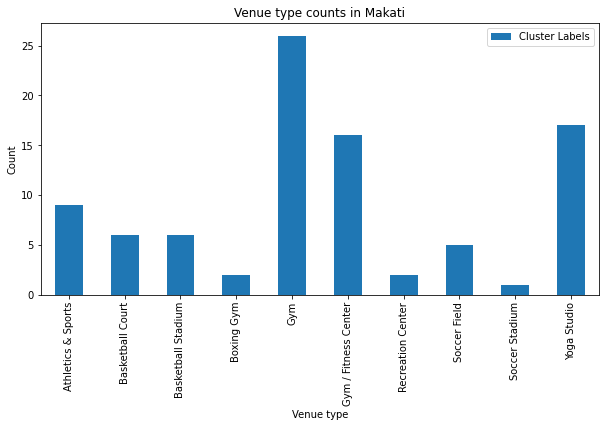

In [92]:
plt_all = sport_and_recreation_venues_clustered.groupby(['Venue Category'], as_index=False).count().plot(kind='bar', 
                                                                     x='Venue Category', y='Cluster Labels',
                                                                     figsize = (10,5))
plt_all.set_title('Venue type counts in Makati')
plt_all.set_xlabel('Venue type')
plt_all.set_ylabel('Count')

For the whole of Makati, Gyms/Fitness Centers (general fitness gyms that have weightlifting facilities, cardio, personal training, etc.) and Yoga Studios seem to be the most frequent.

Let's analyze the venue breakdown for each cluster.

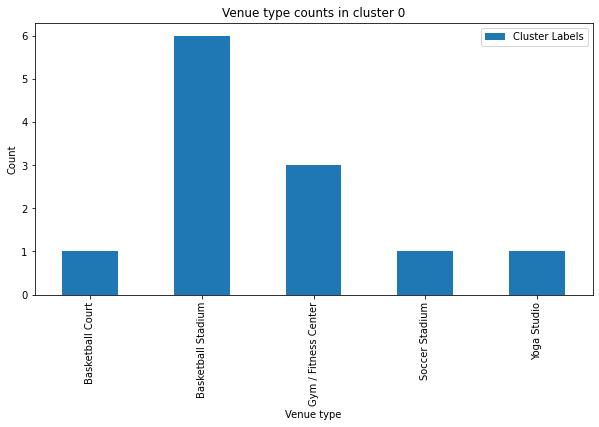

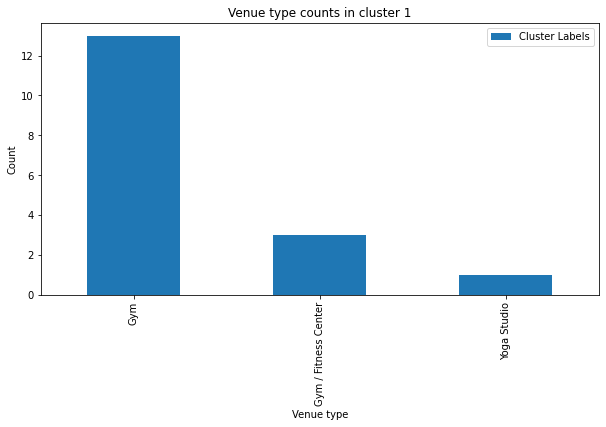

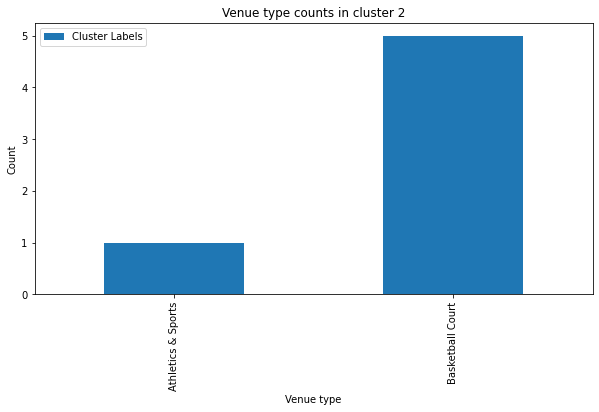

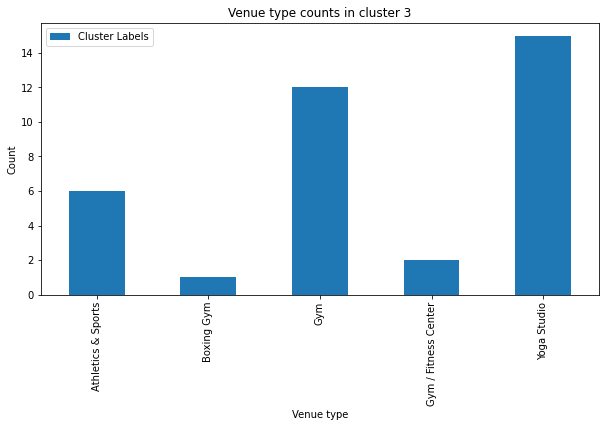

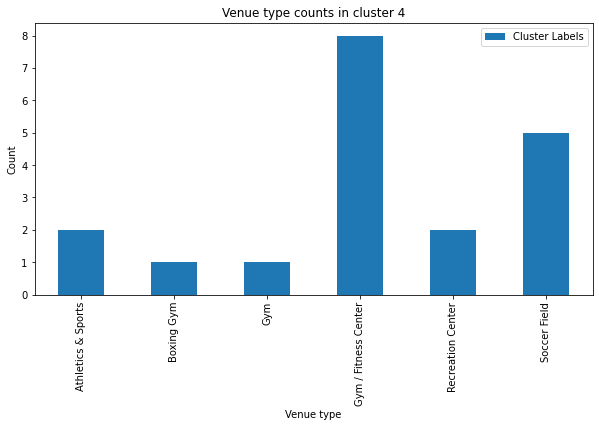

In [93]:
def cluster_breakdown(cluster_n):
    cluster_data = sport_and_recreation_venues_clustered[sport_and_recreation_venues_clustered['Cluster Labels'] == cluster_n]
    plt = cluster_data.groupby(['Venue Category'], as_index=False).count().plot(kind='bar', 
                                                                         x='Venue Category', y='Cluster Labels',
                                                                         figsize = (10,5))
    plt.set_title('Venue type counts in cluster ' + str(cluster_n))
    plt.set_xlabel('Venue type')
    plt.set_ylabel('Count')

for n in range(kclusters):
    cluster_breakdown(n)
    

For cluster 0, the most frequent venue type is Basketball Stadium/Court. The second most is Gym/Fitness Center.

For cluster 1, the top two types are other Gym or Gym/Fitness Center.

For cluster 2, the top type is Basketball Court.

For cluster 3, the top type is Yoga Studio, with Gym coming in second.

For cluster 4, the top two types are Gym/Fitness Center, and Soccer Field.

## Starting a new Gym/Fitness Center

For starting a new Gym/Fitness Center, areas in cluster 2 is the best option - these areas do not have enough of the same venue type.

Let's look at the areas in cluster 2 in the map with the cloropeth of the target areas:

In [96]:
cluster_2 = sport_and_recreation_venues_clustered[sport_and_recreation_venues_clustered["Cluster Labels"] == 2]

map_cluster_2 = folium.Map(location=[map_location[0], map_location[1]], zoom_start=12)
for lat, lng, venue_name in zip(cluster_2['Venue Latitude'], cluster_2['Venue Longitude'], cluster_2['Venue']):
    label = venue_name
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cluster_2)  
    
map_cluster_2

In [111]:
for n in cluster_2['Area'].unique():
    print(n)

Rizal Commercial Banking Corporation
Cembo and South Cembo
East Rembo–Malapad na Bato
Pembo
Pio del Pilar


From the data we see that we have five potential candidate areas for starting a Gym/Fitness area:
- Rizal Commercial Banking Corporation
- Cembo and South Cembo
- East Rembo–Malapad na Bato
- Pembo
- Pio del Pilar

All the venues in cluster 2 have a lack of competition based on venue type while still being in Makati and having access to the dense population with large per-capita income

## Discussion

Metro Manila is a large metropolitan area, and with an emerging population comes the need for more recreational activities for a population with growning spending potential. We provided a method for analyzing the viability of starting a Gym/Fitness center to take advantage of this situation, by looking into several factors.

The need arose to identify the area with good access to a dense population with high per-capita income. To do this, we looked at data for population density and per-capita income, and found that **Makati** is the best option, with the highest per-capita income in Metro Manila and good population density.

We queried data from the **Foursquare API** to determine which venues and venue types are available in Makati. We used the list of venues in Makati by location, based on the zip codes in its area.

We used **K-means clustering** to determine the clusters of areas that are most similar. In each cluster, we looked at the frequency of each venue type to determine which cluster of areas has the least competition for our selected venue type - by picking the cluster that had low frequency of Gym/Fitness Centers.

## Conclusion

From the data, we found that the areas to look at when starting a new Gym/Fitness center are:

- Rizal Commercial Banking Corporation
- Cembo and South Cembo
- East Rembo–Malapad na Bato
- Pembo
- Pio del Pilar

All of the above mentioned areas are in Makati, which has the highest income per capita in Metro Manila, and has access to a dense population.